In [80]:
import sys

sys.path.append("../")  # go to parent dir

%load_ext autoreload
%autoreload 2


from pathlib import Path
from matplotlib import pyplot as plt
from ddmtools.analysis import DDM
import numpy as np

project_path = (Path(".") / ".." / ".." / "..").resolve()
data_path = project_path / "data"

experiment = "2BD01_1__middle1"
experiment_path = data_path / experiment

MAX_WORKERS = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
project_path

WindowsPath('C:/Users/jeppe/Code/DDMTools')

In [82]:
CROP_SIZE = (128, 128)


ddm = DDM.from_folder(
    experiment_path,
    framerate=1.0,
    micrometre_per_pixel=0.234,
    temperature=273.0 + 21.0,
    viscosity=0.9775e-3,
)
# patch framerate
ddm.framerate = len(ddm.stack) / 10.0

ddm.stack.crop(CROP_SIZE)
ddm.stack.preload()
ddm.stack.compress()

Text(0.5, 0.98, 'Frame 1 - Frame 2')

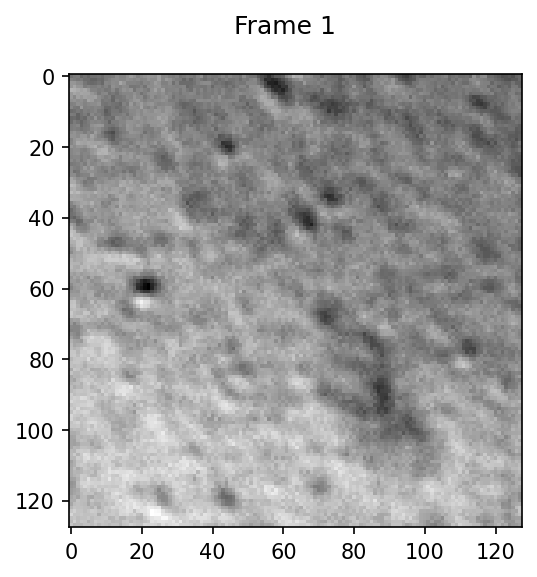

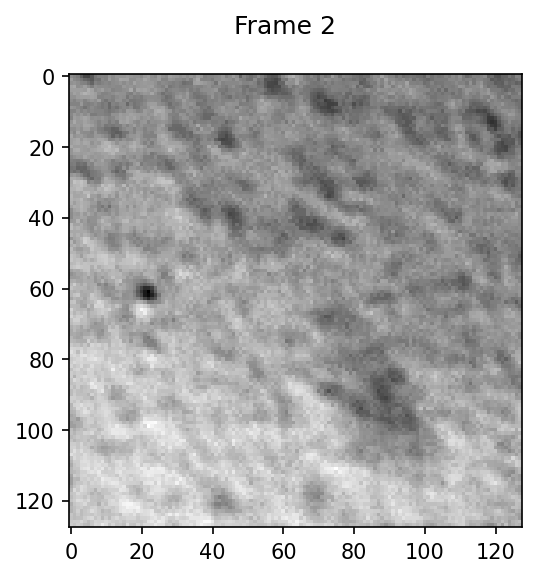

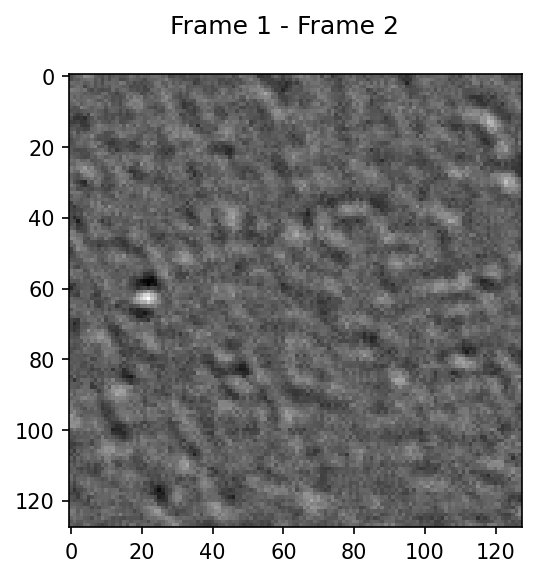

In [83]:
frame1 = ddm.stack[10]
frame2 = ddm.stack[20]

fig = plt.figure(dpi=150)
plt.imshow(frame1, plt.cm.gray)
fig.suptitle("Frame 1")

fig = plt.figure(dpi=150)
plt.imshow(frame2, plt.cm.gray)
fig.suptitle("Frame 2")

fig = plt.figure(dpi=150)
plt.imshow(frame1 - frame2, plt.cm.gray)
fig.suptitle("Frame 1 - Frame 2")

Text(0.5, 0.98, 'Differential Spectrum')

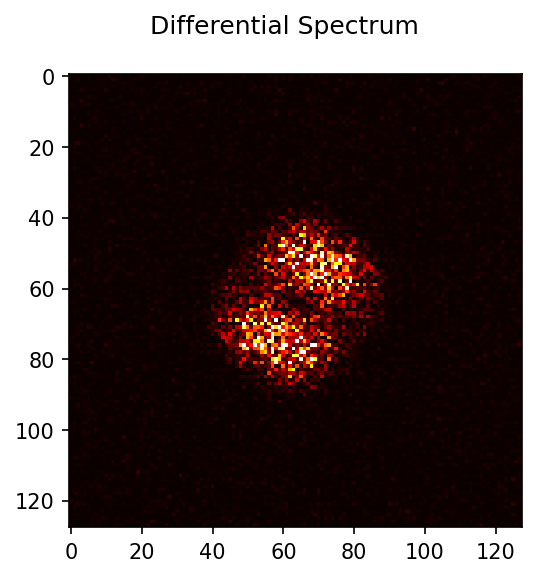

In [84]:
# Show a differential spectrum
diff = ddm.get_differential_spectrum(10, 20)
fig = ddm.plot_differential_spectrum(diff, 3)
fig.set_dpi(150)
fig.suptitle("Differential Spectrum")

Text(0.5, 0.98, 'Frame 1, Time averaged signal')

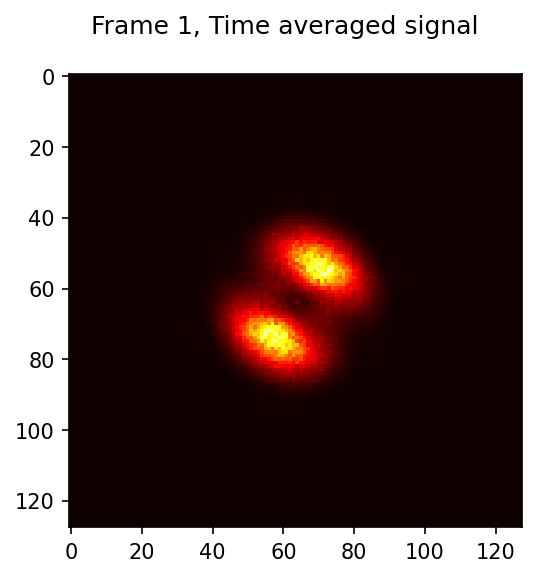

In [85]:
# Show time average
average = ddm.get_time_average(10, max_couples=300)

fig = ddm.plot_time_average(average, brightness=1.0)
fig.set_dpi(150)
fig.suptitle("Frame 1, Time averaged signal")

<Figure size 900x600 with 0 Axes>

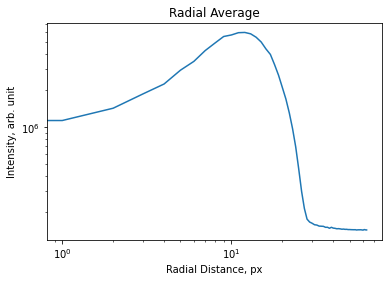

In [86]:
# Show radial average
# We can radially average since we expect isotropy

rad_average = ddm.get_radial_average(average)
fig = ddm.plot_radial_average(rad_average)
fig

In [87]:
# taus = ddm.get_log_spaced_taus(300)
taus = np.array(list(range(1, len(ddm.stack))))
# taus = np.array(range(len(ddm.stack)))

times = ddm.taus_to_times(taus)
iqtaus = ddm.analyse(taus, max_couples=20, workers=MAX_WORKERS)

100%|██████████| 988/988 [00:27<00:00, 36.51it/s]


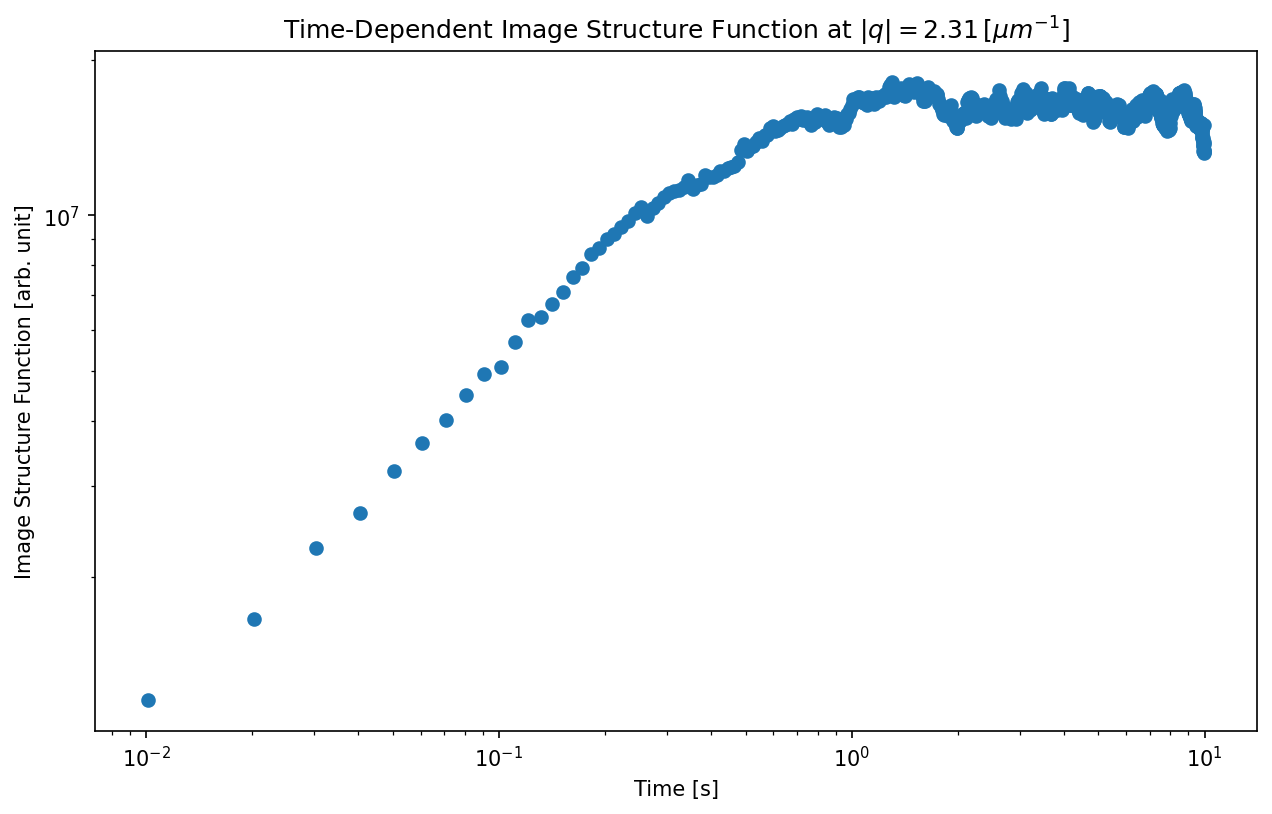

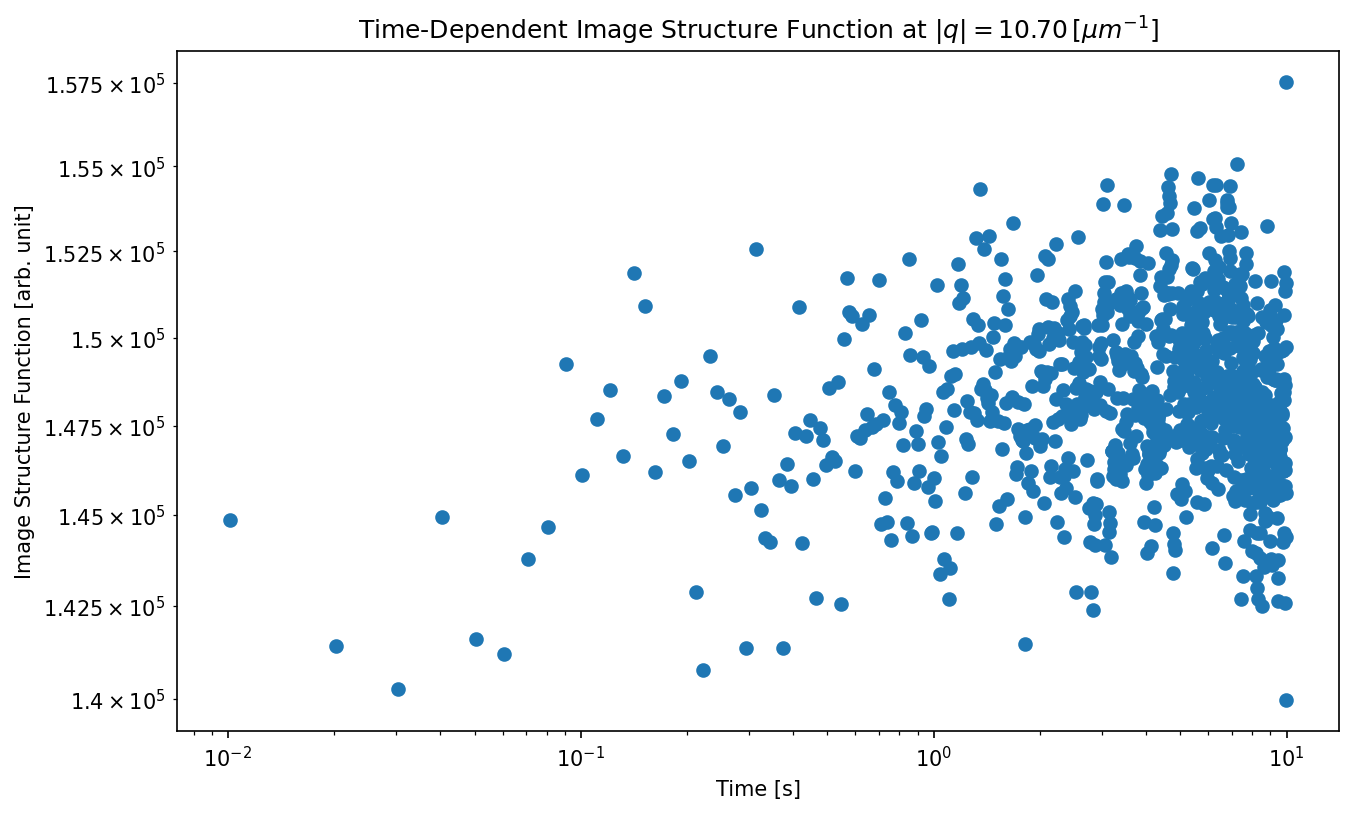

In [88]:
fig = ddm.plot_image_structure_function(10)
fig = ddm.plot_image_structure_function(50)
# fig = ddm.plot_image_structure_function(100)

In [89]:
qs = ddm.iqtaus_to_qs()
# print(len(times), len(qs))

In [90]:
# %lprun -f ddm.fit_image_structure_functions_lmfit ddm.fit_image_structure_functions_lmfit(1)
dispersity_order = 2
min_result = ddm.fit_image_structure_functions_polydisperse(
    dispersity_order, method_sequence=["least_squares"], max_nfev=100_000
)
# a.params.pretty_print()

# DOF = (n-1) + q(1+1+1+(n-1))
# DOF = -1 + n + q(2+n)
# DOF = -1 + n + +2q + qn
# DOF = qn + 2q + n -1
# q = 64, n = 1 => DOF = 192
# q = 64, n = 2 => DOF = 257
# q = 64, n = 3 => DOF = 322
# q = 64, n = 4 => DOF = 387
# q = 64, n = 5 => DOF = 452
# q = 64, n = 6 => DOF = 517

# Speed: (for 10000 evals, N=2, q = 64)
# loop based method: 1:41
# Array based method: 40.4
# Array based method with njit: 1:27
# Array based method with fastmath: 1:27

print(f"Objective function evaluations: {min_result.minimizer_result.nfev}")


# assert False  # Prevent running over

  0%|          | 0/100000 [00:00<?, ?it/s]

Doing fit 1/1 using method `least_squares`...


  2%|▏         | 1807/100000 [00:26<23:44, 68.93it/s]

Done.
Objective function evaluations: 7


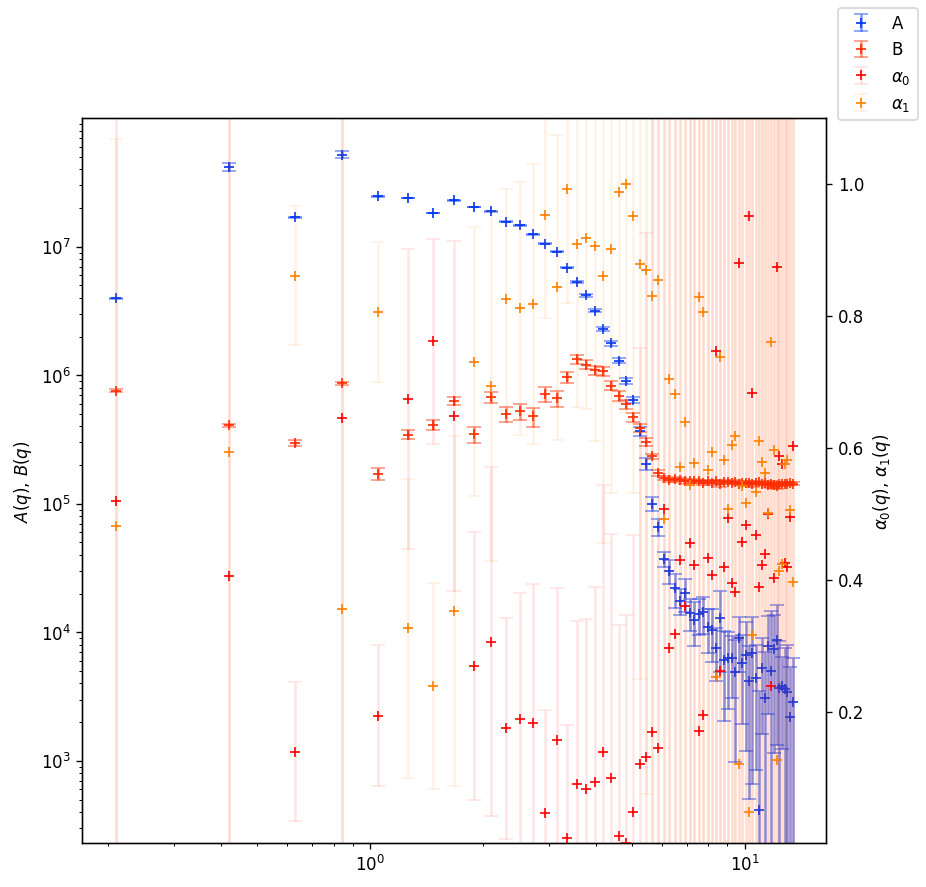

In [91]:
fig = min_result.plot_image_structure_function_params()

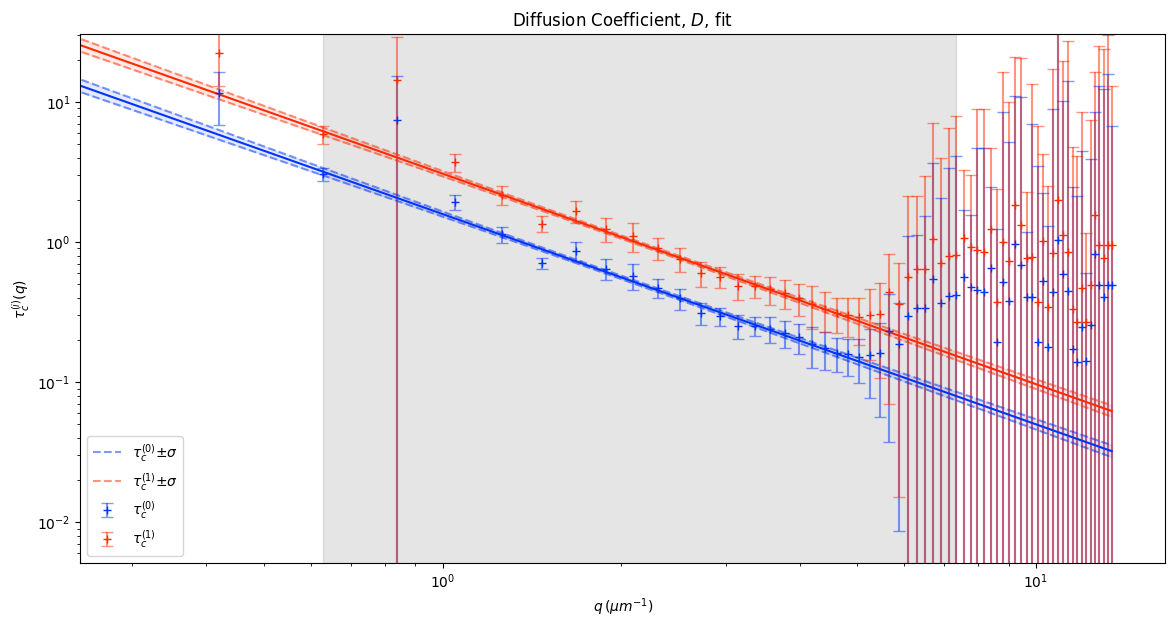

In [96]:
fit_result = min_result.fit_diffusion_coefficients(minimal_r_squared=0.97)
fig = fit_result.plot_diffusion_coeff_fit()

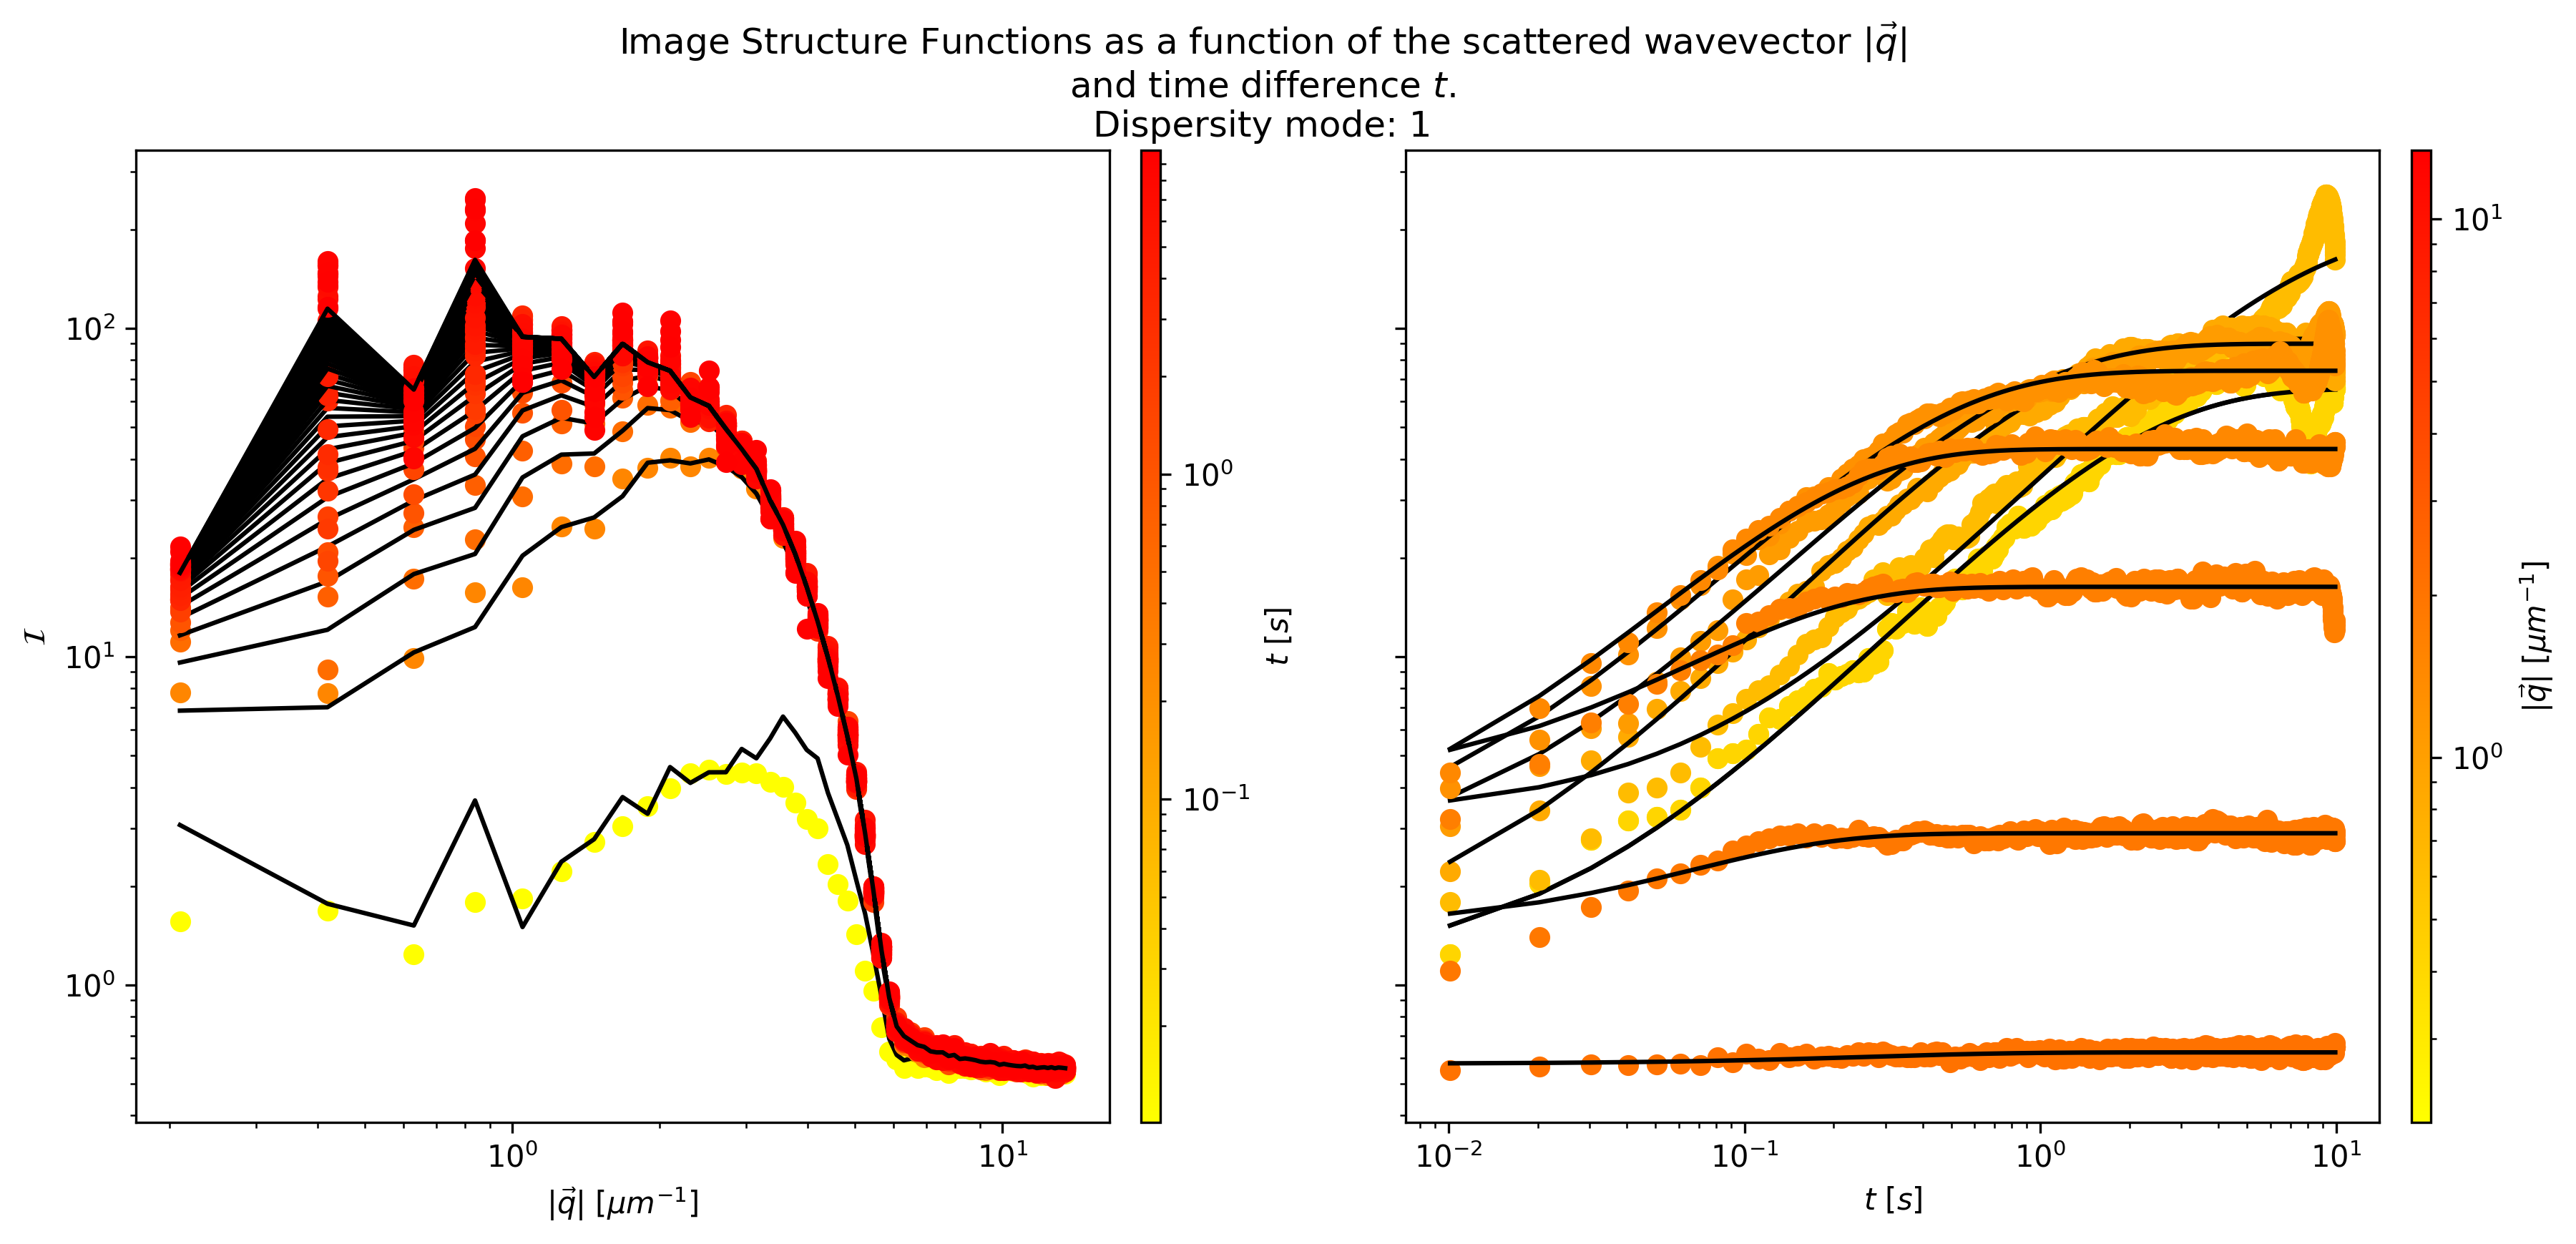

In [93]:
fig = fit_result.plot_image_structure_functions(1, q_interval=25)

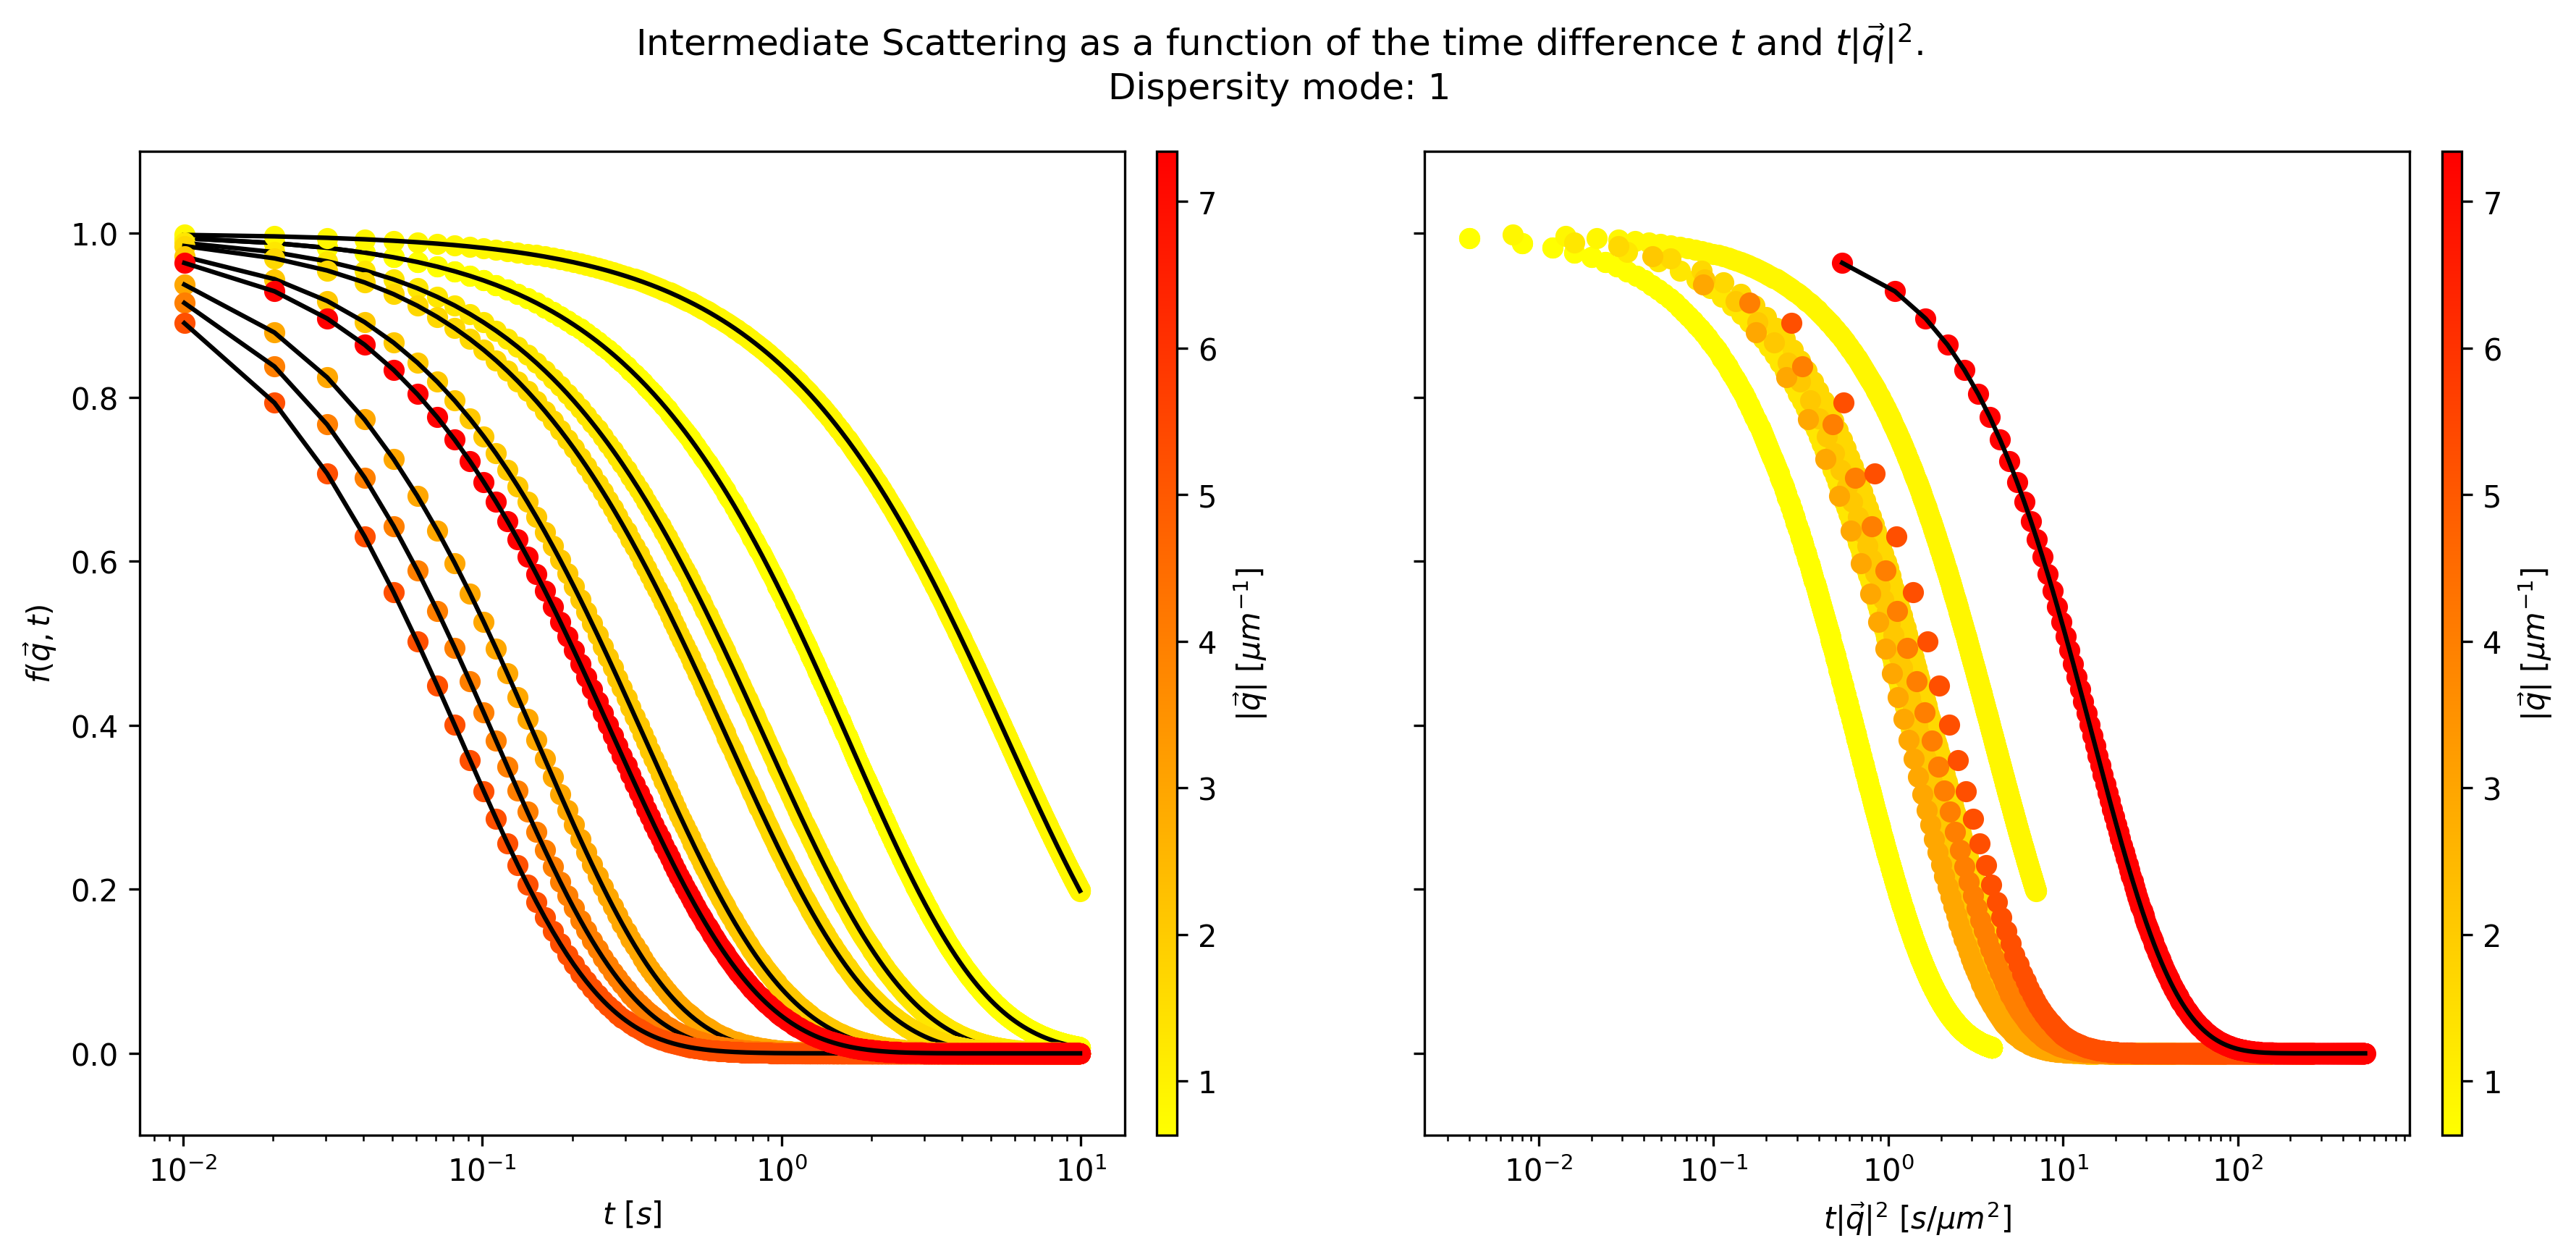

In [94]:
fig = fit_result.plot_intermediate_scattering_function(1)

In [95]:
print(fit_result.get_diffusion_coefficients())
print(fit_result.get_particle_diameters())

# A: 0.211e-6
# B: 0.46e-6
# D: 0.977e-6

[0.6308993175880033+/-0.026227451552940546, 0.32483352444255764+/-0.014052661670595773]
[1.2895989045196758e-07+/-5.36106029093891e-09, 2.504689348859297e-07+/-1.0835566331974682e-08]
